# Import necessary libraries
We import all required libraries: data handling with pandas and numpy, machine learning with scikit-learn, and visualization with matplotlib and seaborn.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load and clean the dataset
We load the dataset, parse dates, handle missing values, and apply filtering to retain relevant and high-quality data. We also extract month and year for modeling.

In [113]:
data = pd.read_csv("cleaned_dataset.csv")
data["Date"] = pd.to_datetime(data["Date"], format="%Y-%m", errors="coerce")
data.replace(-1, np.nan, inplace=True)

data = data.dropna(subset=["Date", "Average delay of all trains at arrival"])

data = data[data["Number of scheduled trains"] > 0]
data = data[~data["Departure station"].str.contains("No information", na=False)]
data = data[~data["Arrival station"].str.contains("No information", na=False)]
data = data[data["Average delay of all trains at arrival"] < 58]

data["Month"] = data["Date"].dt.month
data["Year"] = data["Date"].dt.year

# Select features
We define the list of numerical features to use in our model. Features with too many missing values are automatically excluded.

In [114]:
feature_cols = [
    "Average journey time", "Number of scheduled trains", "Number of cancelled trains",
    "Number of trains delayed at departure", "Average delay of late trains at departure",
    "Average delay of all trains at departure", "Number of trains delayed at arrival",
    "Average delay of late trains at arrival", "Number of trains delayed > 15min",
    "Average delay of trains > 15min (if competing with flights)", "Number of trains delayed > 30min",
    "Number of trains delayed > 60min", "Pct delay due to external causes",
    "Pct delay due to infrastructure", "Pct delay due to traffic management",
    "Pct delay due to rolling stock", "Pct delay due to station management and equipment reuse",
    "Pct delay due to passenger handling (crowding, disabled persons, connections)",
    "Number train active", "Pct cancel", "Pct depart delay rate", "Pct arrival delay rate", "Severe delay rate"
]
features_df = data[feature_cols].dropna(axis=1)
used_feature_cols = features_df.columns.tolist()

# Prepare input matrix X and target y
We construct the feature matrix X and the target variable y.

In [115]:
X = data[["Departure station", "Arrival station", "Month", "Year"] + used_feature_cols]
y = data["Average delay of all trains at arrival"]

# Encode categorical features
We use one-hot encoding to transform station names into binary indicators, allowing them to be used in the machine learning model.

In [116]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
station_encoded = ohe.fit_transform(X[["Departure station", "Arrival station"]])
station_names = ohe.get_feature_names_out(["Departure station", "Arrival station"])
station_df = pd.DataFrame(station_encoded, columns=station_names)

X = X.drop(columns=["Departure station", "Arrival station"]).reset_index(drop=True)
X = pd.concat([X, station_df.reset_index(drop=True)], axis=1)
X = X.fillna(X.mean())

# Split data into train/test sets
The dataset is split into training (75%) and test (25%) sets to evaluate model performance.

In [117]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

# Feature selection using a Random Forest
We apply model-based feature selection to retain only the most important predictors.

In [118]:
sel = SelectFromModel(RandomForestRegressor(n_estimators=500, random_state=123), threshold="median")
sel.fit(x_train, y_train)
x_train_sel = sel.transform(x_train)
x_test_sel = sel.transform(x_test)

# Train final Random Forest model
A RandomForestRegressor with optimized hyperparameters is trained on the selected features.

In [119]:
best_params = {'n_estimators': 500, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'random_state': 123}
model = RandomForestRegressor(**best_params)
model.fit(x_train_sel, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=500, random_state=123)

# Evaluate the model
We assess model performance using the Mean Absolute Error and the R² score.

In [120]:
y_pred = model.predict(x_test_sel)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MAE = {mae:.2f} minutes")
print(f"R² = {r2:.5f}")

MAE = 1.96 minutes
R² = 0.44131


# Plot predictions vs actual values
A scatterplot helps visualize how close the predictions are to the true values.

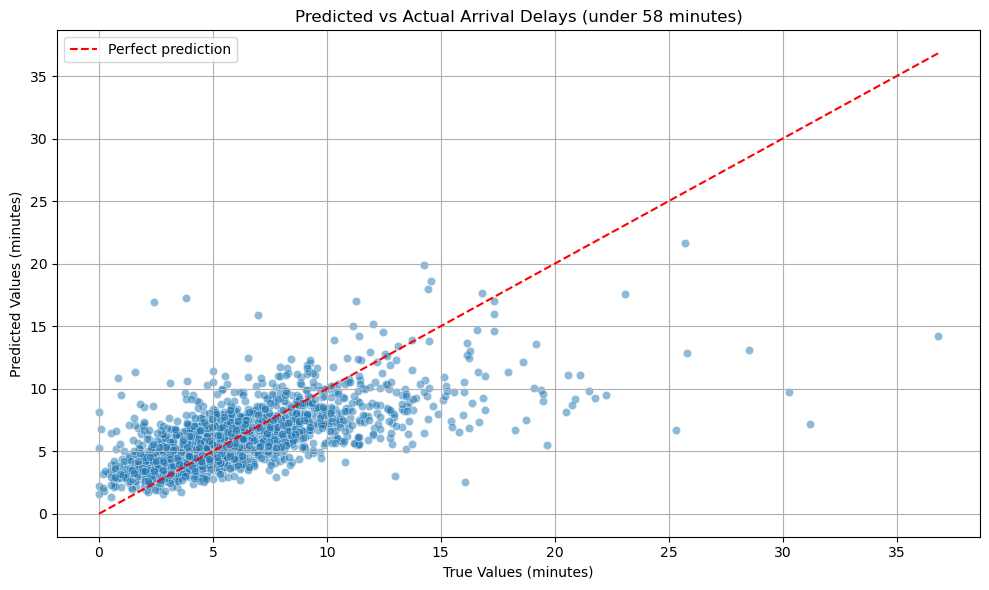

In [121]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect prediction")
plt.xlabel("True Values (minutes)")
plt.ylabel("Predicted Values (minutes)")
plt.title("Predicted vs Actual Arrival Delays (under 58 minutes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Analyze prediction residuals by month
We compute and visualize residuals (differences between predictions and reality) over time to identify trends or periods of bias.

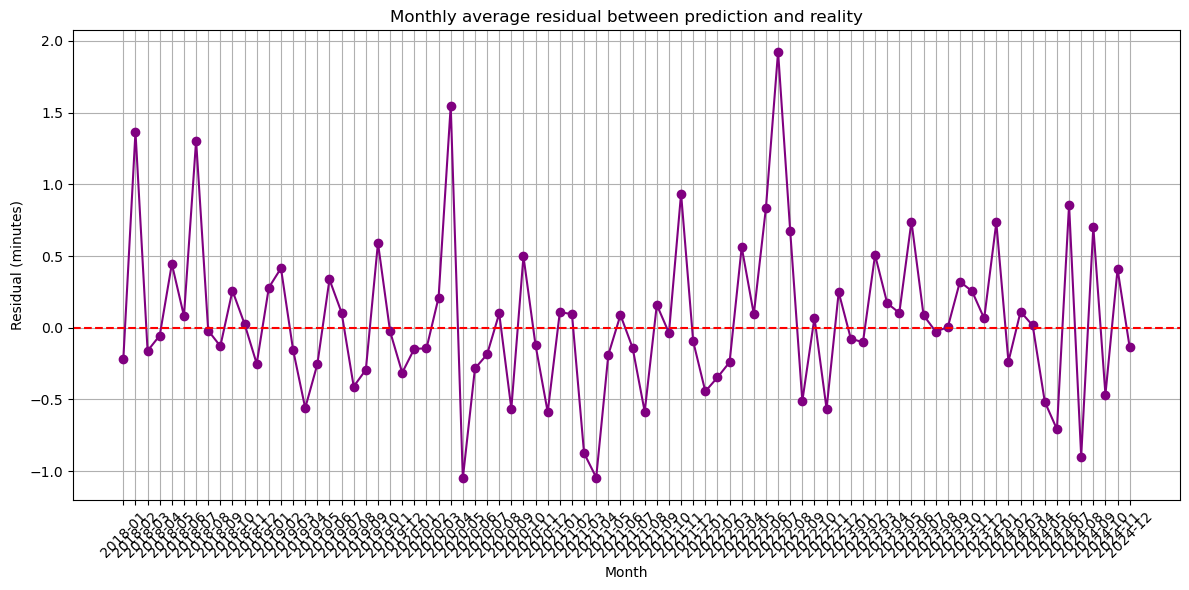

In [122]:
data["Predicted delay"] = model.predict(sel.transform(X))
data["Residual"] = data["Average delay of all trains at arrival"] - data["Predicted delay"]
residuals_by_month = data.groupby(data["Date"].dt.to_period("M"))["Residual"].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(residuals_by_month["Date"].astype(str), residuals_by_month["Residual"], marker="o", color="purple")
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=45)
plt.title("Monthly average residual between prediction and reality")
plt.xlabel("Month")
plt.ylabel("Residual (minutes)")
plt.grid(True)
plt.tight_layout()
plt.show()